### Tamagotchi POMCP
pam o.p. 2018
tiger problem 
for debugging POMCP solution method (MCTS in PO framework)

In [1]:
# imports
from random import randint
import numpy as np
import random
import datetime # for limiting calculation to wall clock time
import math
import copy
import matplotlib.pyplot as plt


In [3]:
# # game class
# # gaining money to buy items in store can be simple time cost/money reward exchange
# # agent decides when to gain money, and then which items to buy/apply to tamagotchi
class TigerProblem():
    def __init__(self,obs_truth = 0.8):
#         self.state = ('tiger-left' if random.random() < 0.5 else 'tiger-right')
        self.obs_truth = obs_truth
        self.all_states = set(['tiger-left','tiger-right'])
        
    # this contains the transition function for the MDP
    def next_state(self, state, action):
        
        assert action in ['listen','open-left','open-right'], "invalid action"
        
        if action == 'listen':
            return state
        elif action == 'open-left':
            return ('tiger-left' if random.random() < 0.5 else 'tiger-right')
        elif action == 'open-right':            
            return ('tiger-left' if random.random() < 0.5 else 'tiger-right')
       
    # observation function for the POMDP
    def observation(self, state, action):  
        
        assert action in ['listen','open-left','open-right'], "invalid action"
        
        all_s = self.all_states
        
        if action == 'listen':
            if random.random() < self.obs_truth:
                return state
            else:
                other = [st for st in self.all_states if st != state]
                return other[0]
        else:
            return []
        
    # Take a sequence of game states representing the full game history, and return the full list
    # of actions that are legal actions
    def legal_actions(self,state_hist): 
        return ['listen','open-left','open-right']
    
    # Should this be the length of state_history (how long tama alive for)? or is it trial by trial rwd?
    def reward(self, state, action):
        if action == 'listen':
            return 0
        elif action == 'open-left':
            return -100 if state == 'tiger-left' else 10
        elif action == 'open-right':            
            return -100 if state == 'tiger-right' else 10
            
    # GENERATOR MODEL OF GAME
    # returns next state, observation, and reward given an action taken in given state
    # takes tuple state
    def G_model(self,state,action):
        s = self.next_state(state,action)
        obs = self.observation(state,action)
        rwd = self.reward(state,action) # note that this should be more like immediate reward of state, not long-term?
        return s, obs, rwd
    

In [20]:
# Debug step!

s = ('tiger-left' if random.random() < 0.5 else 'tiger-right')
print(state)
game = TigerProblem()

s,o,r = game.G_model(s,'listen')
print(s,o,r)
s,o,r = game.G_model(s,'listen')
print(s,o,r)
s,o,r = game.G_model(s,'listen')
print(s,o,r)
s,o,r = game.G_model(s,'listen')
print(s,o,r)

s,o,r = game.G_model(s,'open-left')
print(s,o,r)

tiger-left
tiger-right tiger-right 0
tiger-right tiger-left 0
tiger-right tiger-right 0
tiger-right tiger-left 0
tiger-right [] 10


In [5]:
#class adapted from github.com/cbarrick/POMCP-Blackjack

class SearchTree:
    def __init__(self, particles=[], action = None, visit=1, value=0, **kwargs): #, action = None
        self.particles=particles
        self.visit=visit
        self.value=value
        self.action=action
        self.children=[] # set()
        
    def expand(self, legal_actions):
        for a in legal_actions:
            self.children.append(SearchTree(action=a))
        
    # upper confidence bound value for given node "child"
    def ucb(self, child):
#         print("self.visit=",self.visit," len of self.children=",len(self.children))
        logval = math.log(self.visit) #, len(self.children))
        div = logval / child.visit
        return math.sqrt(div)
    
    def isleaf(self):
        if len(self.children) == 0:
            return True
        else:
            return False
        
    def print_tree(self, level=0):
        print('\t' * level + repr(self.action) + ' val:' + repr(self.value) + ' visits:' + repr(self.visit))
        for child in self.children:
            child.print_tree(level+1)
        
    # I think this might be useful if i need to check the structure of the tree
#     # e.g. that all children of action nodes are observations and vice versa
#     def isaction(self):
#         if self.action:
#             return True
#         else:
#             return False  

In [6]:
# Initial state distribution
def sample_prior():
    s = ('tiger-left' if random.random() < 0.5 else 'tiger-right')
    return s

# when filtering particles, this is the rule to keep one given a real observation
def keep_particle(part, real_obs):
    if real_obs == []:
        return True
    else:
        if part == real_obs:
            return True
    return False

# generate a new particle from one randomly sampled from current belief (e.g., just add a lil noise)
def new_particle(part):
    s = ('tiger-left' if random.random() < 0.5 else 'tiger-right')
    return s

In [28]:
class POMCP(object):
    
    def __init__(self, 
                 game=TigerProblem(),
                 discount=0.8,
                 depth=0,
                 epsilon=1e-7,
                 explore=1,
                 n_particles=100,
                 reinvigoration=20, 
                 **kwargs):
        
#         self.context = {}
        self.game = game
        self.discount = discount
        self.depth = depth
        self.epsilon = epsilon
        self.explore = explore
        self.n_particles = n_particles
        self.reinvigoration = reinvigoration
        self.G = game.G_model        
        # list of all possible actions
#         self.actions = kwargs.get('actions') 
        
        seconds = kwargs.get('time',30)
        self.calculation_time = datetime.timedelta(seconds=seconds)
        self.max_moves = kwargs.get('max_moves',20)
        
    # Particle filtering
    def update_belief(self,tree,obs):
        particles = [part for part in tree.particles if keep_particle(part,obs)]
        for _ in range(self.reinvigoration):
            particles.append(new_particle(random.choice(particles)))
        tree.particles = particles
        return tree

    # choose a move! "search" algorithm, which begins at a root of a search tree and decides the 
    # next optimal action given the recent real observation and legal actions at the current state
    def choose_move(self,obs,context,legal_actions):
        begin = datetime.datetime.utcnow()
        reinvig = False
        while (datetime.datetime.utcnow() - begin) < self.calculation_time:
            tree = context.get('pomcp_root')    
            if tree is None: # if we are at the root of the whole tree: no history
                tree = SearchTree()
                context['pomcp_root'] = tree
                context['full_tree'] = []
                # sample s from initial state dist
                tree.particles = [sample_prior() for _ in range(self.n_particles)]
                part = random.choice(tree.particles)
            if tree is not None and reinvig == False:
                particles = [part for part in tree.particles if keep_particle(part,obs)]
                for _ in range(self.reinvigoration):
                    particles.append(new_particle(random.choice(particles)))
                tree.particles = particles
                part = random.choice(tree.particles)
                reinvig = True
            
            self.simulate(part,tree,0)
        
        children = [child for child in tree.children if child.action in legal] #filter(lambda child: child.action in legal_actions, tree.children)
        child_vals = np.array([child.value for child in children])
        favechildren = np.argwhere(child_vals == np.amax(child_vals))
        child = children[random.choice(favechildren.flatten().tolist())]
        
        context['full_tree'].append(tree)
        context['pomcp_root'] = child 
        return child.action
    
    # update the values of the actions in the tree by best-first search, simulating actions
    # and their effects (rewards) using G 
    def simulate(self,part,tree,depth):
        # if we have simulated past the point of caring (past our discount horizon)
        if self.discount**depth < self.epsilon or depth >= self.max_moves:
            return 0 # reward of these faraway futures is meaningless, nothing
        
        # get legal actions
        legal = self.game.legal_actions(part)
        
        # if the current history does not have a node in the search tree, e.g., tree has no child nodes,
        # then expand
        if len(tree.children) == 0:
            tree.expand(legal)
            return self.rollout(part,depth)
        
        # if only one legal action, take it
        if len(legal)==1:
            action = legal[0]
        else:
            # if current history does have a node, so we know the value of its action children,
            # use ucb to choose best action given current value fxns
            children = [child for child in tree.children if child.action in legal] #filter(lambda child: child.action in legal_actions, tree.children)
            child_vals = np.array([child.value + self.explore * tree.ucb(child) for child in children])
            favechildren = np.argwhere(child_vals == np.amax(child_vals))
            child = children[random.choice(favechildren.flatten().tolist())]
        
            action = child.action
        
        next_state, next_obs, r = self.G(part,action)
        new_part = next_state 
        reward = r + self.discount * self.simulate(new_part, child, depth + 1) 
        tree.particles.append(new_part)
        
        tree.visit += 1
        child.visit += 1
        child.value += (reward - child.value) / child.visit
        
        return reward
        
        
    def rollout(self,state,depth):
        # if we have rolled out past the point of caring (past our discount horizon)
        if self.discount**depth < self.epsilon or depth >= self.max_moves:
            return 0 
        
        legal = self.game.legal_actions([state])
        a = random.choice(legal) # random rollout policy
        
        next_state, obs, r = self.G(state,a)

        return r + self.discount * self.rollout(next_state, depth+1)
        
        
        

In [8]:
# Create a tiger problem game and a POMCP agent
s = ('tiger-left' if random.random() < 0.5 else 'tiger-right')
game = TigerProblem()
agent = POMCP(game, discount = 0.1, time = 1.)

In [9]:
# Check that the tree runs simulations to choose the next action using the choose_move() method

print("INITIAL STATE: ")
print(s) # initial tiger problem state

obs = []
legal = game.legal_actions(_)
context = {}

action = agent.choose_move(obs,context,legal)
print("Taking action:", action)
state = game.next_state(s,action)
game.reward(s,action)

INITIAL STATE: 
tiger-right
Taking action: open-left


10

In [14]:
# Now, let the POMCP do its thing for several actions in a row

# Initialize the tiger problem
s = ('tiger-left' if random.random() < 0.5 else 'tiger-right')
game = TigerProblem(obs_truth=0.95)
    
print("INITIAL STATE: ")
print(s) # initial tiger state

agent = POMCP(game, time = 0.5, explore = 50, n_particles = 5, reinvigoration = 1)

action_seq = []
state = s
obs = []
context = {}
R = 0

while len(action_seq) <= 20: # play for a certain amount of time (better rule?)

    legal = game.legal_actions([state])
    action = agent.choose_move(obs,context,legal)
    action_seq.append(action)
    print('Action %i: True state is %s'% (len(action_seq), state))
    print("Taking action %s."% action)
    
    obs = game.observation(state,action)
    if obs!=[]:
        print("observed ",obs)

    state = game.next_state(state,action)
    r = game.reward(state,action)
    R = R + r
    print("Reward so far: ",R)

    
print("game over!")

INITIAL STATE: 
tiger-right
Action 1: True state is tiger-right
Taking action listen.
observed  tiger-right
Reward so far:  0
Action 2: True state is tiger-right
Taking action listen.
observed  tiger-left
Reward so far:  0
Action 3: True state is tiger-right
Taking action open-left.
Reward so far:  -100
Action 4: True state is tiger-left
Taking action listen.
observed  tiger-left
Reward so far:  -100
Action 5: True state is tiger-left
Taking action listen.
observed  tiger-left
Reward so far:  -100
Action 6: True state is tiger-left
Taking action listen.
observed  tiger-left
Reward so far:  -100
Action 7: True state is tiger-left
Taking action listen.
observed  tiger-left
Reward so far:  -100
Action 8: True state is tiger-left
Taking action listen.
observed  tiger-left
Reward so far:  -100
Action 9: True state is tiger-left
Taking action listen.
observed  tiger-left
Reward so far:  -100
Action 10: True state is tiger-left
Taking action listen.
observed  tiger-left
Reward so far:  -100
A

In [141]:
# If desired, can view the search tree from the current root node (e.g., the last action taken)
# Warning !! this will give a pretty large output (depending on size of search tree)
tree = context['pomcp_root']
tree.print_tree()


'open-right' val:-4485.767613902942 visits:974
	'open-right' val:-4367.9151639791935 visits:300
		'open-right' val:-4145.911105760418 visits:104
			'open-right' val:-3588.987255712952 visits:24
				'listen' val:-3063.75 visits:6
					'open-right' val:-2808.75 visits:4
						'open-left' val:-1810.0 visits:2
							'open-right' val:0 visits:1
							'listen' val:0 visits:1
							'open-left' val:0 visits:1
						'open-right' val:0 visits:1
						'listen' val:0 visits:1
					'listen' val:0 visits:1
					'open-left' val:0 visits:1
				'open-left' val:-1780.0 visits:2
					'open-right' val:0 visits:1
					'listen' val:0 visits:1
					'open-left' val:0 visits:1
				'open-right' val:-3457.7408389136904 visits:14
					'open-right' val:-2827.5 visits:4
						'open-right' val:-1895.0 visits:2
							'open-right' val:0 visits:1
							'listen' val:0 visits:1
							'open-left' val:0 visits:1
						'listen' val:0 visits:1
						'open-left' val:0 visits:1
					'open-left' val:-2030.0 visits:2
					

In [25]:
# While viewing the entire search tree from the initial root (the start of the game) would be gigantic,
# we can at least see how it chose the first action by seeing the child values for each action
root = context['full_tree'][0]
# root.print_tree()
for i in range(3):
    print(root.children[i].action, root.children[i].value, root.children[i].visit)

listen -16.651559085822694 3813
open-left -142.229612074909 4
open-right -126.49593815413053 10


In [26]:
# determine how many times the agent chose each action
all_act = set(action_seq)
for i in all_act:
    count = sum([1 for a in action_seq if a==i])
    print(i,':',count,'times')

open-left : 1 times
listen : 19 times
open-right : 1 times


In [27]:
# let's observe the sequence of actions the tree chose!
print("\nNumber of actions taken: ",len(action_seq))
print("Reward so far: ",R)
print(action_seq)


Number of actions taken:  21
Reward so far:  -90
['listen', 'open-right', 'listen', 'listen', 'listen', 'listen', 'listen', 'listen', 'listen', 'listen', 'listen', 'listen', 'open-left', 'listen', 'listen', 'listen', 'listen', 'listen', 'listen', 'listen', 'listen']


In [29]:
# now let's compare the performance of different exploration coeff C

storeobservations = []
storeactions = []
storerewards = []
cs = [0,1,1.4,2,2.5,3,4,5,10,50,100]

for c in cs:
    print("C = ", c)
    # Initialize the tiger
    s = ('tiger-left' if random.random() < 0.5 else 'tiger-right')
    game = TigerProblem()

    print("INITIAL STATE: ")
    print(s) # initial tiger state

    agent = POMCP(game, time = 1., explore = c)

    action_seq = []
    obs_seq = []
    state = s
    obs = []
    context = {}
    R = 0
    
    while len(action_seq) <= 20: # play for a certain amount of time (better rule?)

        legal = game.legal_actions([state])
        action = agent.choose_move(obs,context,legal)
        action_seq.append(action)
        print('Action %i: True state is %s'% (len(action_seq), state))
        print("Taking action %s."% action)

        obs = game.observation(state,action)
        obs_seq.append(obs)

        if obs!=[]:
            print("observed ",obs)

        state = game.next_state(state,action)
        r = game.reward(state,action)
        R = R + r
        print("Reward so far: ",R)
    
    storeobservations.append([obs_seq])
    storeactions.append([action_seq])
    storerewards.append(R)

    
    


C =  0
INITIAL STATE: 
tiger-left
Action 1: True state is tiger-left
Taking action listen.
observed  tiger-left
Reward so far:  0
Action 2: True state is tiger-left
Taking action open-left.
Reward so far:  10
Action 3: True state is tiger-right
Taking action listen.
observed  tiger-right
Reward so far:  10
Action 4: True state is tiger-right
Taking action listen.
observed  tiger-right
Reward so far:  10
Action 5: True state is tiger-right
Taking action listen.
observed  tiger-left
Reward so far:  10
Action 6: True state is tiger-right
Taking action listen.
observed  tiger-right
Reward so far:  10
Action 7: True state is tiger-right
Taking action listen.
observed  tiger-right
Reward so far:  10
Action 8: True state is tiger-right
Taking action open-right.
Reward so far:  20
Action 9: True state is tiger-left
Taking action listen.
observed  tiger-left
Reward so far:  20
Action 10: True state is tiger-left
Taking action listen.
observed  tiger-right
Reward so far:  20
Action 11: True stat

Action 1: True state is tiger-left
Taking action listen.
observed  tiger-left
Reward so far:  0
Action 2: True state is tiger-left
Taking action open-left.
Reward so far:  10
Action 3: True state is tiger-right
Taking action listen.
observed  tiger-right
Reward so far:  10
Action 4: True state is tiger-right
Taking action open-right.
Reward so far:  -90
Action 5: True state is tiger-right
Taking action listen.
observed  tiger-right
Reward so far:  -90
Action 6: True state is tiger-right
Taking action listen.
observed  tiger-right
Reward so far:  -90
Action 7: True state is tiger-right
Taking action open-left.
Reward so far:  -190
Action 8: True state is tiger-left
Taking action listen.
observed  tiger-left
Reward so far:  -190
Action 9: True state is tiger-left
Taking action listen.
observed  tiger-left
Reward so far:  -190
Action 10: True state is tiger-left
Taking action listen.
observed  tiger-left
Reward so far:  -190
Action 11: True state is tiger-left
Taking action listen.
observ

Action 1: True state is tiger-left
Taking action open-left.
Reward so far:  -100
Action 2: True state is tiger-left
Taking action listen.
observed  tiger-left
Reward so far:  -100
Action 3: True state is tiger-left
Taking action listen.
observed  tiger-left
Reward so far:  -100
Action 4: True state is tiger-left
Taking action listen.
observed  tiger-left
Reward so far:  -100
Action 5: True state is tiger-left
Taking action listen.
observed  tiger-left
Reward so far:  -100
Action 6: True state is tiger-left
Taking action listen.
observed  tiger-left
Reward so far:  -100
Action 7: True state is tiger-left
Taking action listen.
observed  tiger-left
Reward so far:  -100
Action 8: True state is tiger-left
Taking action listen.
observed  tiger-left
Reward so far:  -100
Action 9: True state is tiger-left
Taking action listen.
observed  tiger-right
Reward so far:  -100
Action 10: True state is tiger-left
Taking action listen.
observed  tiger-left
Reward so far:  -100
Action 11: True state is t

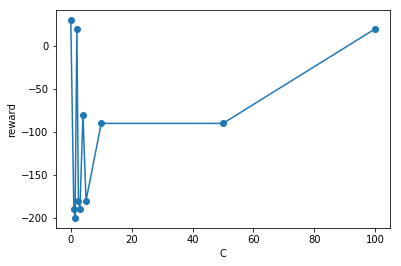

In [30]:
import matplotlib.pyplot as plt

cashmoney = storerewards #[i for (i,a) in storerewards]
plt.plot(cs,cashmoney,'o-')
plt.xlabel("C")
plt.ylabel("reward")
plt.show()

# storerewards

In [22]:
# now let's compare the performance of different computation times 

storetobservations = []
storetactions = []
storetrewards = []
times = [0.0001,0.001,0.01,0.1,0.5,1.,1.5,2.0,3.0,3.5,4.0]

for t in times:
    print("Computation time = ", t)
    
    s = ('tiger-left' if random.random() < 0.5 else 'tiger-right')
    game = TigerProblem()

    print("INITIAL STATE: ")
    print(s) # initial tamagotchi state

    agent = POMCP(game, time = t, explore = 50)

    action_seq = []
    obs_seq = []
    state = s
    obs = []
    context = {}
    R = 0
    
    while len(action_seq) <= 20: # play for a certain amount of time (better rule?)

        legal = game.legal_actions([state])
        action = agent.choose_move(obs,context,legal)
        action_seq.append(action)
        print('Action %i: True state is %s'% (len(action_seq), state))
        print("Taking action %s."% action)

        obs = game.observation(state,action)
        obs_seq.append(obs)

        if obs!=[]:
            print("observed ",obs)

        state = game.next_state(state,action)
        r = game.reward(state,action)
        R = R + r
        print("Reward so far: ",R)
    
    storetobservations.append([obs_seq])
    storetactions.append([action_seq])
    storetrewards.append(R)
    

Computation time =  0.0001
INITIAL STATE: 
tiger-left
Action 1: True state is tiger-left
Taking action listen.
observed  tiger-left
Reward so far:  0
Action 2: True state is tiger-left
Taking action listen.
observed  tiger-left
Reward so far:  0
Action 3: True state is tiger-left
Taking action listen.
observed  tiger-right
Reward so far:  0
Action 4: True state is tiger-left
Taking action open-left.
Reward so far:  -100
Action 5: True state is tiger-left
Taking action open-right.
Reward so far:  -200
Action 6: True state is tiger-right
Taking action open-left.
Reward so far:  -190
Action 7: True state is tiger-right
Taking action open-right.
Reward so far:  -180
Action 8: True state is tiger-left
Taking action open-right.
Reward so far:  -170
Action 9: True state is tiger-left
Taking action listen.
observed  tiger-left
Reward so far:  -170
Action 10: True state is tiger-left
Taking action listen.
observed  tiger-left
Reward so far:  -170
Action 11: True state is tiger-left
Taking actio

Action 6: True state is tiger-left
Taking action listen.
observed  tiger-left
Reward so far:  -100
Action 7: True state is tiger-left
Taking action listen.
observed  tiger-left
Reward so far:  -100
Action 8: True state is tiger-left
Taking action listen.
observed  tiger-left
Reward so far:  -100
Action 9: True state is tiger-left
Taking action listen.
observed  tiger-left
Reward so far:  -100
Action 10: True state is tiger-left
Taking action listen.
observed  tiger-left
Reward so far:  -100
Action 11: True state is tiger-left
Taking action listen.
observed  tiger-left
Reward so far:  -100
Action 12: True state is tiger-left
Taking action listen.
observed  tiger-left
Reward so far:  -100
Action 13: True state is tiger-left
Taking action listen.
observed  tiger-left
Reward so far:  -100
Action 14: True state is tiger-left
Taking action listen.
observed  tiger-left
Reward so far:  -100
Action 15: True state is tiger-left
Taking action listen.
observed  tiger-right
Reward so far:  -100
Act

Action 4: True state is tiger-right
Taking action listen.
observed  tiger-right
Reward so far:  10
Action 5: True state is tiger-right
Taking action listen.
observed  tiger-left
Reward so far:  10
Action 6: True state is tiger-right
Taking action open-left.
Reward so far:  -90
Action 7: True state is tiger-left
Taking action listen.
observed  tiger-right
Reward so far:  -90
Action 8: True state is tiger-left
Taking action listen.
observed  tiger-left
Reward so far:  -90
Action 9: True state is tiger-left
Taking action listen.
observed  tiger-left
Reward so far:  -90
Action 10: True state is tiger-left
Taking action listen.
observed  tiger-right
Reward so far:  -90
Action 11: True state is tiger-left
Taking action listen.
observed  tiger-left
Reward so far:  -90
Action 12: True state is tiger-left
Taking action listen.
observed  tiger-left
Reward so far:  -90
Action 13: True state is tiger-left
Taking action listen.
observed  tiger-left
Reward so far:  -90
Action 14: True state is tiger

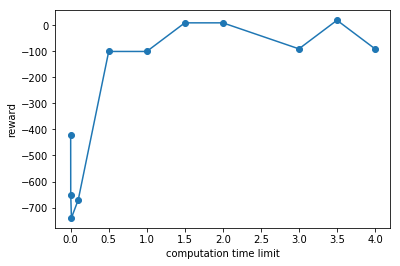

In [23]:
cashtmoney = storetrewards #[i for (i,a) in storetrewards]
plt.plot(times,cashtmoney,'o-')
plt.xlabel("computation time limit")
plt.ylabel("reward")
plt.show()

In [31]:
storetrewards

[-420, -650, -740, -670, -100, -100, 10, 10, -90, 20, -90]